In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, ReLU, Flatten

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

In [3]:
samples_per_class = 5000
no_of_classes = 2
directory = "/content/gdrive/MyDrive/GW_SOP/Code/debugging/1D-CNN Binary Classification/Signal_HIDDEN_in_strain_data/ALIGO_noise/Test 3/data/"

In [7]:
noise_df = pd.read_csv(directory + "Final_Merged_Noise_Reduced_No_Abs.csv", header=None)
noise = noise_df.values.astype(float)
noise = np.repeat(noise, 5000, 0)


data_BBH_df = pd.read_csv(directory + "Final_BBH_Merged_Noise_Signal.csv", header=None)
data_BBH = data_BBH_df.values.astype(float)

In [8]:
X = np.concatenate((noise, data_BBH), axis=0)
X = X[:10000, :]
print(X.shape)

(10000, 16384)


In [9]:
noise_df = None
data_BBH_df = None
noise = None
data_BBH = None

In [10]:
y = [int(i/samples_per_class) for i in range(samples_per_class*no_of_classes)]
y = tf.keras.utils.to_categorical(y)
print(y.shape)

(10000, 2)


In [11]:
X *= 1e19
print(X)

[[-14.34762651  -4.36566417  -6.60616946 ...   6.63648971  -8.6147687
    4.05785029]
 [-14.34762651  -4.36566417  -6.60616946 ...   6.63648971  -8.6147687
    4.05785029]
 [-14.34762651  -4.36566417  -6.60616946 ...   6.63648971  -8.6147687
    4.05785029]
 ...
 [  4.14312095  -0.88039047   4.12192507 ... -11.24627899  10.50681582
   -2.40695071]
 [  4.14312095  -0.88039047   4.12192507 ... -11.24627899  10.50681582
   -2.40695071]
 [  4.14312095  -0.88039047   4.12192507 ... -11.24627899  10.50681582
   -2.40695071]]


In [12]:
X = np.expand_dims(X, axis=-1)
print(X.shape)

(10000, 16384, 1)


In [13]:
def create_model():    
    model = Sequential()

    model.add(Conv1D(16, 16, input_shape = (16384,1)))
    model.add(MaxPool1D(4, 4))
    model.add(ReLU())
    model.add(Conv1D(32, 8))
    model.add(MaxPool1D(4, 4))
    model.add(ReLU())
    model.add(Conv1D(64, 8))
    model.add(MaxPool1D(4, 4))
    model.add(ReLU())
    model.add(Conv1D(128, 8))
    model.add(MaxPool1D(4, 4))
    model.add(ReLU())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/3
63/63 [==============================] - 4s 46ms/step - loss: 0.2120 - accuracy: 0.9670
Epoch 2/3
63/63 [==============================] - 3s 43ms/step - loss: 8.7672e-06 - accuracy: 1.0000
Epoch 3/3
63/63 [==============================] - 3s 43ms/step - loss: 3.2884e-06 - accuracy: 1.0000
---------------------------------------------------------------------------------------------------------
Epoch 1/3
63/63 [==============================] - 3s 44ms/step - loss: 0.1536 - accuracy: 0.9669
Epoch 2/3
63/63 [==============================] - 3s 43ms/step - loss: 4.2440e-06 - accuracy: 1.0000
Epoch 3/3
63/63 [==============================] - 3s 43ms/step - loss: 1.6285e-06 - accuracy: 1.0000
---------------------------------------------------------------------------------------------------------
Epoch 1/3
63/63 [==============================] - 3s 44ms/step - loss: 0.3807 - accuracy: 0.9448
Epoch 2/3
63/63 [==============================] - 3s 44ms/step - loss: 2.3772e-05 - a

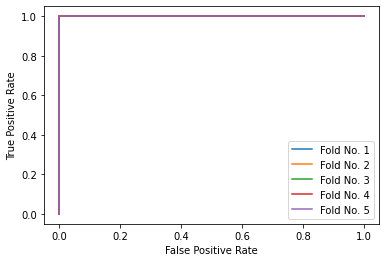

In [26]:
N_splits = 5
n_epochs = 3

kf = KFold(n_splits = N_splits, shuffle = True)
acc = [0 for i in range(n_epochs+1)]
loss = [0 for i in range(n_epochs)]
precision = 0
recall = 0
score = 0
cm = np.zeros((2,2))

precision_train = 0
recall_train = 0
score_train = 0
cm_train = np.zeros((2,2))
k = 1

final = plt.figure()
plt.xlabel('False Positive Rate', figure = final)
plt.ylabel('True Positive Rate', figure = final)

for train_index, test_index in kf.split(X):

    fig = plt.figure()
    plt.xlabel('False Positive Rate', figure = fig)
    plt.ylabel('True Positive Rate', figure = fig)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    # print(y_train)
    # print(y_test)

    model = create_model()
    history = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs)

    print("---------------------------------------------------------------------------------------------------------")

    tmp_acc = history.history['accuracy']
    tmp_loss = history.history['loss']

    for i in range(n_epochs):
        acc[i+1] += tmp_acc[i]
        loss[i] += tmp_loss[i]

    pred = model.predict(X_test)
    y_pred = np.argmax(pred, axis = 1)
    y_true = np.argmax(y_test, axis = 1)

    pred_train = model.predict(X_train)
    y_pred_train = np.argmax(pred_train, axis = 1)
    y_true_train = np.argmax(y_train, axis = 1)

    precision += precision_score(y_true, y_pred, average='binary')
    recall += recall_score(y_true, y_pred, average='binary')
    score += f1_score(y_true, y_pred, average='binary')
    cm = np.add(cm, confusion_matrix(y_true, y_pred, labels=[0, 1]))

    precision_train += precision_score(y_true_train, y_pred_train, average='binary')
    recall_train += recall_score(y_true_train, y_pred_train, average='binary')
    score_train += f1_score(y_true_train, y_pred_train, average='binary')
    cm_train = np.add(cm_train, confusion_matrix(y_true_train, y_pred_train, labels=[0, 1]))

    pos_probs = pred[:,1]
    fpr, tpr, _ = roc_curve(y_true, pos_probs)
    plt.plot(fpr, tpr, figure = fig, label = 'Fold No. ' + str(k))
    plt.legend(loc='lower right')
    plt.savefig(directory + 'roc_'+str(N_splits)+'-fold_'+str(k)+'.png', figure = fig)
    plt.close()
    plt.plot(fpr, tpr, figure = final, label = 'Fold No. ' + str(k))
    k += 1

plt.legend(loc='lower right')
plt.savefig(directory[:-5]+"screenshots/test_roc_"+str(N_splits)+".png")
plt.show()

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-Score: 1.000


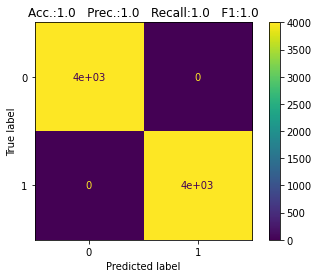

In [27]:
# Train Data

final_accuracy = acc[n_epochs]/N_splits
final_precision = precision_train/N_splits
final_recall = recall_train/N_splits
final_score = score_train/N_splits
final_cm = cm_train/N_splits

print('Accuracy: %.3f' % final_accuracy)
print('Precision: %.3f' % final_precision)
print('Recall: %.3f' % final_recall)
print('F1-Score: %.3f' % final_score)

disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=[0, 1])
disp.plot()
plt.title('Acc.:'+str(round(final_accuracy, 3))+'   Prec.:'+str(round(final_precision, 3))+'   Recall:'+str(round(final_recall, 3))+'   F1:'+str(round(final_score, 3)))
plt.savefig(directory[:-5]+"screenshots/train_cm_"+str(N_splits)+".png")
plt.show()

Precision: 1.000
Recall: 1.000
F1-Score: 1.000


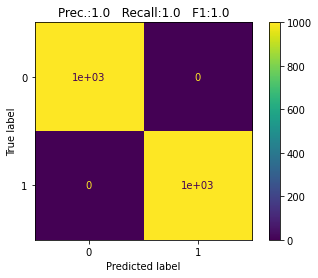

In [28]:
# Test Data

final_precision = precision/N_splits
final_recall = recall/N_splits
final_score = score/N_splits
final_cm = cm/N_splits

print('Precision: %.3f' % final_precision)
print('Recall: %.3f' % final_recall)
print('F1-Score: %.3f' % final_score)

disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=[0, 1])
disp.plot()
plt.title('Prec.:'+str(round(final_precision, 3))+'   Recall:'+str(round(final_recall, 3))+'   F1:'+str(round(final_score, 3)))
plt.savefig(directory[:-5]+"screenshots/test_cm_"+str(N_splits)+".png")
plt.show()

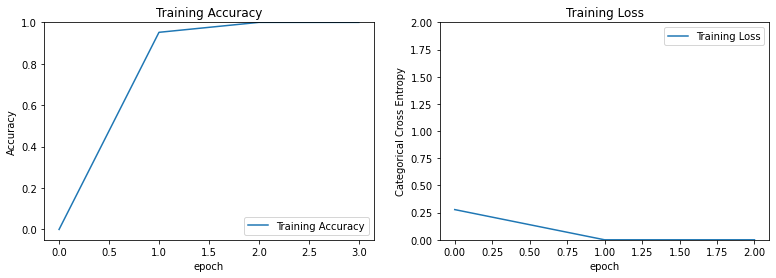

In [29]:
acc_1 = [acc[i]/N_splits for i in range(n_epochs+1)]
loss_1 = [loss[i]/N_splits for i in range(n_epochs)]

plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_1, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(loss_1, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,2])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.savefig(directory[:-5]+"screenshots/graph_"+str(N_splits)+".png")
plt.show()